# DSLab Homework 1 - Data Science with CO2

## Hand-in Instructions

- __Due: 19.03.2024 23h59 CET__
- `./setup.sh` before you can start working on this notebook.
- `git push` your final verion to the master branch of your group's Renku repository before the due date.
- check if `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Carbosense

The project Carbosense establishes a uniquely dense CO2 sensor network across Switzerland to provide near-real time information on man-made emissions and CO2 uptake by the biosphere. The main goal of the project is to improve the understanding of the small-scale CO2 fluxes in Switzerland and concurrently to contribute to a better top-down quantification of the Swiss CO2 emissions. The Carbosense network has a spatial focus on the City of Zurich where more than 50 sensors are deployed. Network operations started in July 2017.

<img src="http://carbosense.wdfiles.com/local--files/main:project/CarboSense_MAP_20191113_LowRes.jpg" width="500">

<img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_ZLMT_3.JPG" width="156">  <img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_sensor_SMALL.jpg" width="300">

## Description of the homework

In this homework, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich from the Carbosense project. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city **zones** and the zone in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

## Prior knowledge

The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains, forests), are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. **The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.** 

## To start with

The following csv files in the `../data/carbosense-raw/` folder will be needed: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It contains the CO2 measurements `CO2`, the name of the site `LocationName`, a unique sensor identifier `SensorUnit_ID`, and the time instance in which the measurement was taken `timestamp`.
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp `Timestamp`. For each `SensorUnit_ID`, the temperature and the humidity can be found in the corresponding columns of the dataframe `{SensorUnit_ID}.temperature`, `{SensorUnit_ID}.humidity`.
    
3. `sensor_metadata_updated.csv`

   __Description__: It contains the name of the site `LocationName`, the zone index `zone`, the altitude in meters `altitude`, the longitude `LON`, and the latitude `LAT`. 

Import the following python packages:

In [2]:
#!pip install pandas
#!pip install numpy
#!pip install scikit-learn
#!pip install plotly
#!pip install seaborn
#!pip install yellowbrick

In [3]:
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import plotly.graph_objects as go
import os
import random

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
rseed = 6 # random seed for group F, F is sixth letter of alphabet
random.seed(rseed)

## PART I: Handling time series with pandas (10 points)

In [6]:
DATA_DIR = 'data/'

 ### a) **8/10**

 Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe. 

 * The merged dataframe contains:
     - index: the time instance `timestamp` of the measurements
     - columns: the location of the site `LocationName`, the sensor ID `SensorUnit_ID`, the CO2 measurement `CO2`, the `temperature`, the `humidity`, the `zone`, the altitude`, the longitude `lon` and the latitude `lat`.

 | timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
 |:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
 |    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |



 * For each measurement (CO2, humidity, temperature), __take the average over an interval of 30 min__. 

 * If there are missing measurements, __interpolate them linearly__ from measurements that are close by in time.

 __Hints__: The following methods could be useful

 1. ```python 
 pandas.DataFrame.resample()
 ``` 
 https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
     
 2. ```python
 pandas.DataFrame.interpolate()
 ```
 https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
     
 3. ```python
 pandas.DataFrame.mean()
 ```
 https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
     
 4. ```python
 pandas.DataFrame.append()
 ```
 https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [7]:
from datetime import datetime

# Pull in CO2 measurements, cast timestamp as dt object
co2 = pd.read_csv(os.path.join(DATA_DIR, 'CO2_sensor_measurements.csv'), sep = '\t', parse_dates=[0])
# Resample on timestamp using 30-minute intervals, group by LocationName and SensorUnit (see merged dataframe shell above))
co2 = co2.groupby(['LocationName', 'SensorUnit_ID']).resample('30min', on='timestamp').mean()['CO2'].reset_index()

# Pull in temperature and humidity, cast timestamp as dt object
th = pd.read_csv(os.path.join(DATA_DIR, 'temperature_humidity.csv'), sep = '\t', parse_dates=[0])
# Resample, melt df to extract sensor unit prefix from columns
th = th.resample('30min', on = 'Timestamp').mean().melt(ignore_index=False).reset_index()
th[['SensorUnit_ID', 'var']] = tuple(th['variable'].apply(lambda x: x.split('.')))
# Reshape into expected format after melt (rename Timestamp per the shell df above)
th = th.drop(columns=['variable']).set_index(['Timestamp', 'SensorUnit_ID', 'var'])
th = th.unstack().reset_index().set_index(['Timestamp', 'SensorUnit_ID'])
th.columns = [col[1] for col in th.columns]
th = th.reset_index().rename(columns={'Timestamp':'timestamp'})

# Import sensors and keep pertinent columns only (rename lon and lat per the shell df above)
sensors = pd.read_csv(os.path.join(DATA_DIR, 'sensors_metadata_updated.csv'), sep = ',', index_col=0)
sensors = sensors[['LocationName', 'zone', 'altitude', 'LON', 'LAT']].rename(columns={'LON':'lon', 'LAT':'lat'})

# Merge data
co2['SensorUnit_ID'] = co2['SensorUnit_ID'].astype(str)
co2_merged = co2.merge(th, on=['SensorUnit_ID', 'timestamp'], how='outer').merge(sensors, on='LocationName', how='left', indicator=False) # change indicator to True to see missing metadata

# Interpolate missing values
co2_merged = co2_merged.set_index(['SensorUnit_ID', 'timestamp'])
co2_merged[['CO2', 'humidity', 'temperature']] = co2_merged[['CO2', 'humidity', 'temperature']].interpolate(method='linear')

# Reorder columns
co2_merged = co2_merged.reset_index().set_index(['timestamp'])
co2_merged = co2_merged[['LocationName', 'SensorUnit_ID', 'CO2', 'temperature', 'humidity', 'zone', 'altitude', 'lon', 'lat']]

# Remove sensors missing data
co2_merged = co2_merged[~co2_merged.SensorUnit_ID.isin(['1117', '1174'])] # sensor missings data
co2_merged.head()

LocationName SensorUnit_ID         CO2  temperature  \
timestamp                                                                 
2017-10-01 00:00:00         ZGHD          1014  595.004391    11.396667   
2017-10-01 00:30:00         ZGHD          1014  597.017879    11.325000   
2017-10-01 01:00:00         ZGHD          1014  596.487010    11.240000   
2017-10-01 01:30:00         ZGHD          1014  598.787639    11.260000   
2017-10-01 02:00:00         ZGHD          1014  595.366394    11.290000   

                      humidity  zone  altitude       lon        lat  
timestamp                                                            
2017-10-01 00:00:00  92.440806   2.0     413.5  8.523256  47.370446  
2017-10-01 00:30:00  91.770691   2.0     413.5  8.523256  47.370446  
2017-10-01 01:00:00  91.096761   2.0     413.5  8.523256  47.370446  
2017-10-01 01:30:00  91.275734   2.0     413.5  8.523256  47.370446  
2017-10-01 02:00:00  91.061157   2.0     413.5  8.523256  47.370446

### b) **2/10** 

Export the curated and ready to use timeseries to a csv file, and properly push the merged csv to Git LFS.

In [8]:
co2_merged.to_csv(os.path.join(DATA_DIR, 'co2_merged.csv'))

# SKIP THE GIT LFS: see discussion on slack

## PART II: Data visualization (15 points)

### a) **5/15** 
Group the sites based on their altitude, by performing K-means clustering. 
- Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 
- Wite out the formula of metric you use for Elbow curve.
- Perform clustering with the optimal number of clusters and add an additional column `altitude_cluster` to the dataframe of the previous question indicating the altitude cluster index. 
- Report your findings.

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

__Answer:__ 

Optimal cluster count is 4 based on distortion metric.

For a given cluster count *k*, let C<sub>i</sub> be the center of cluster *i* after the K-means clustering algorithm has converged, with 
*i* ∈ ℕ and *i* <= *k*. Let *A<sub>i</sub>* be the set of altitudes in the dataset assigned to cluster *i* by K-means. Per the Yellowbrick [documentation](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html), **distortion** is $\sum_{1 \le i \le k}\sum_{a_i \in A_i}(C_i - a_i)^2$. In words, it's the "sum of squared distances from each point to its assigned center."

**Distortion** is the value plotted in the first graph below. To calculate the optimal k = cluster count, we rely on Yellowbrick's implementation of the knee point detection algorithm, which locates the point along a discrete set of data which closest reflects the point of maximum curvature for a corresponding continuous curve (read more [here](https://raghavan.usc.edu/papers/kneedle-simplex11.pdf)).

The data exhibit a rightward skew (see second graph below). Thus, over 70% of datapoints are assigned to 1 cluster, while the other three clusters are comprised of 8 sensor altitudes, 5 sensor altitudes, and just 1 sensor altitude respectively. 

In [9]:
# Bring in data, pull altitudes, the clustering var (reshape bc sklearn requires two-dimension input)
co2_merged = pd.read_csv(os.path.join(DATA_DIR, 'co2_merged.csv'), index_col='timestamp', parse_dates=[0])
altitudes_w_id = co2_merged[['SensorUnit_ID', 'altitude']].drop_duplicates().dropna().reset_index(drop=True)
altitudes = altitudes_w_id['altitude'].values.reshape(-1,1)

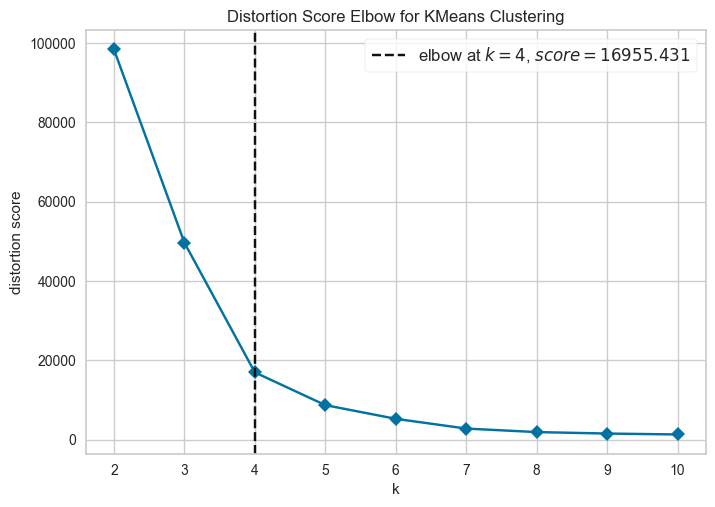

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Use yellowbrick (indeed, it was useful) to plot KMeans elbow
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
km_elbow = KElbowVisualizer(KMeans(n_init=10), k=10, metric='distortion', random_state=rseed, timings=False) # other metrics don't give a useful kink in the curve
km_elbow.fit(altitudes)
km_elbow.show()

In [11]:
# Assign clusters for ideal cluster count K = 4
print("ideal cluster count: ", km_elbow.elbow_value_)
altitudes_w_id['altitude_cluster'] = KMeans(km_elbow.elbow_value_, n_init=10).fit(altitudes).predict(altitudes)
altitudes_w_id.head()

ideal cluster count:  4


SensorUnit_ID  altitude  altitude_cluster
0           1014     413.5                 0
1           1015     439.9                 0
2           1016     402.9                 0
3           1017     410.5                 0
4           1018     413.1                 0

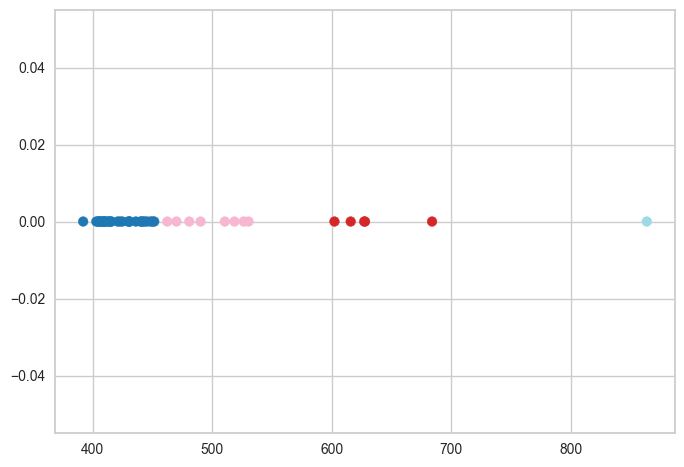

In [12]:
# Visualize clusters
import matplotlib.pyplot as plt
plt.scatter(altitudes, np.zeros_like(altitudes), c=altitudes_w_id['altitude_cluster'], cmap='tab20')
plt.show()

In [13]:
altitudes_w_id['altitude_cluster'].value_counts()

altitude_cluster
0    30
2     8
1     5
3     1
Name: count, dtype: int64

### b) **4/15** 

Use `plotly` (or other similar graphing libraries) to create an interactive plot of the monthly median CO2 measurement for each site with respect to the altitude. 

Add proper title and necessary hover information to each point, and give the same color to stations that belong to the same altitude cluster.

In [14]:
# Attach location names to altitude clusters
locations_w_clusters = altitudes_w_id.merge(right=co2_merged[['SensorUnit_ID','LocationName']].drop_duplicates(), how='left').dropna()
if len(locations_w_clusters[['LocationName']].drop_duplicates()) != len(locations_w_clusters[['LocationName']]):
     print("cluster assignment non-unique by location")

# Resample to monthly average for CO2 by site and altitude
monthly_co2 = co2_merged.reset_index()
monthly_co2 = monthly_co2[['CO2','altitude','LocationName','timestamp']].groupby(['LocationName', 'altitude']).resample('ME', on='timestamp').median().reset_index()
monthly_co2 = monthly_co2.merge(locations_w_clusters, on=['LocationName', 'altitude'])
monthly_co2['month'] = monthly_co2['timestamp'].apply(lambda x: x.strftime('%b %y'))
monthly_co2.head()

LocationName  altitude  timestamp         CO2  SensorUnit_ID  \
0         AJGR     627.8 2017-10-31  334.785793           1122   
1         BSCR     462.3 2017-10-31  474.502250           1120   
2         BUDF     490.2 2017-10-31  422.793126           1124   
3         KBRL     510.5 2017-10-31  410.100150           1176   
4         KTGM     530.3 2017-10-31  444.395518           1211   

   altitude_cluster   month  
0                 1  Oct 17  
1                 2  Oct 17  
2                 2  Oct 17  
3                 2  Oct 17  
4                 2  Oct 17

In [15]:
# scatter, hover info: ['altitude', 'CO2', 'LocationName', 'altitude_cluster', 'timestamp']

import plotly.graph_objects as go
fig = px.scatter(monthly_co2, x='altitude', y='CO2', title='Monthly CO2 Emissions by Altitude', color='altitude_cluster', color_continuous_scale='portland', hover_data=['LocationName', 'month'])
fig.update_layout(
    title='CO2 Measurement by Sensor Location Altitude (Color = Altitude Cluster)',
    xaxis=dict(title='Altitude'),
    yaxis=dict(title='CO2 Measurement'),
    coloraxis_showscale=False)
fig.show()

### c) **6/15**

Use `plotly` (or other similar graphing libraries) to plot an interactive time-varying density heatmap of the mean daily CO2 concentration for all the stations. Add proper title and necessary hover information.

__Hints:__ Check following pages for more instructions:
- [Animations](https://plotly.com/python/animations/)
- [Density Heatmaps](https://plotly.com/python/mapbox-density-heatmaps/)

In [16]:
# Resample to daily average for quantitative info, including CO2 (heatmap color) and temperature,humidity (layover info)
daily_heatmap = co2_merged.reset_index()
daily_heatmap = daily_heatmap[['lon','lat','CO2','timestamp','temperature','humidity']].groupby(['lon', 'lat']).resample('D', on='timestamp').mean()[['CO2', 'temperature', 'humidity']].reset_index()
daily_heatmap = daily_heatmap.rename(columns={'timestamp':'date', 'CO2':'avgCO2', 'temperature':'avgTemp', 'humidity':'avgHum'})
# Bring in unit id and altitude (more layover info)
daily_heatmap = daily_heatmap.merge(co2_merged[['lon','lat','SensorUnit_ID','altitude']].drop_duplicates(), on=['lon','lat'], how = 'left')

In [17]:
avgLat = daily_heatmap['lat'].mean()
avgLon = daily_heatmap['lon'].mean()
print(f"Average latitude: {avgLat}; Average longitude: {avgLon}")

Average latitude: 47.381295037045454; Average longitude: 8.52146280334091


In [18]:
# Interactive heatmap: co2 magnitude, ['avgTemp','avgHum','altitude','SensorUnit_ID'] layover info

import plotly.express as px

fig = px.density_mapbox(daily_heatmap, lat='lat', lon='lon', z='avgCO2', animation_frame="date", radius=5,
                        center=dict(lat=avgLat, lon=avgLon), zoom=9,
                        mapbox_style="open-street-map",
                        custom_data=['avgTemp','avgHum', 'altitude', 'SensorUnit_ID'])
fig.update_layout(title='Heatmap of Average Detected CO2 by Day', width = 500)
fig.update_traces(hovertemplate='<br>'.join([
    'CO2: %{z:.2f}',
    'Temperature: %{customdata[0]:.2f}',
    'Humidity: %{customdata[1]:.2f}',
    'Altitude: %{customdata[2]}',
    'Sensor ID: %{customdata[3]}',
]))
fig.show()


## PART III: Model fitting for data curation (35 points)

### a) **2/35**

The domain experts in charge of these sensors report that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 24. Verify the drift by visualizing the CO2 concentration of the drifting sensor and compare it with some other sensors from the network. 

In [19]:
# filter to 24th, prep to time series chart
drift = co2_merged.reset_index()
drift = drift[drift['timestamp'].dt.day >= 15] # day is all that needs to be handled because all data is october

# Select 5 random locations + ZSBN to show CO2 time series for
locs_to_plot = ['ZSBN'] + random.sample(list(set(drift['LocationName'].values) - {'ZSBN'}), 5)
drift = drift[drift['LocationName'].isin(locs_to_plot)]

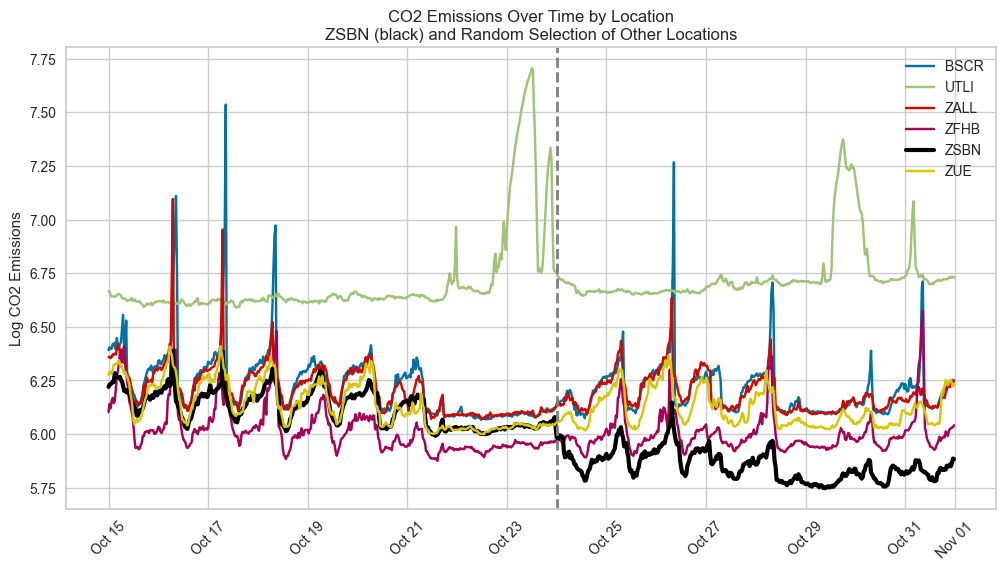

In [20]:
# plot co2 by location, highlight problem location
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt_df = drift.groupby('LocationName')
for location, ts in plt_df:
    if location != "ZSBN":
        plt.plot(ts['timestamp'], np.log(ts['CO2']), label=location)
    else: 
        plt.plot(ts['timestamp'], np.log(ts['CO2']), label=location, color='black', linewidth=3)
plt.title('CO2 Emissions Over Time by Location\nZSBN (black) and Random Selection of Other Locations')

plt.ylabel('Log CO2 Emissions')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %d'))
plt.axvline(pd.to_datetime('2017-10-24 00:00:00'), color='gray', linestyle='--', linewidth=2)
plt.legend(loc='upper right')

### b) **8/35**

The domain experts ask you if you could reconstruct the CO2 concentration of the drifting sensor had the drift not happened. You decide to:
- Fit a linear regression model to the CO2 measurements of the site, by considering as features the covariates not affected by the malfunction (such as temperature and humidity)
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __95% confidence interval__ obtained from cross validation: assume that the error follows a normal distribution and is independent of time.
- What do you observe? Report your findings.

__Note:__ Cross validation on time series is different from that on other kinds of datasets. The following diagram illustrates the series of training sets (in orange) and validation sets (in blue). For more on time series cross validation, there are a lot of interesting articles available online. scikit-learn provides a nice method [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

![ts_cv](https://player.slideplayer.com/86/14062041/slides/slide_28.jpg)

In [21]:
from sklearn.model_selection import TimeSeriesSplit 
import scipy.stats as sps
from sklearn.linear_model import LinearRegression

# Linear regression: datetime object converted to numeric timestamp, 
# Included temperature, humidity
# Excluded location, sensor unit, zone, altitude, lon, lat because they're stable for ZSBN
linreg_df = co2_merged.reset_index()
linreg_df = linreg_df[linreg_df['LocationName'] == "ZSBN"] # filter to particular sensor
linreg_df = linreg_df[['timestamp', 'temperature', 'humidity', 'CO2']]
linreg_df = linreg_df.dropna()

In [22]:
from sklearn.metrics import mean_squared_error

def cross_validation_and_plot(linreg_df, covariates, title):
    pre_drift = linreg_df[linreg_df['timestamp'].dt.day < 24] # filter out post-drift data
    drift_beginning = pre_drift['timestamp'].max()

    # Fitting regression and calculating predictions on all October data (inc. training data)
    linreg_y = pre_drift[['CO2']]
    linreg_X = pre_drift[covariates]
    reg = LinearRegression().fit(linreg_X, linreg_y)
    linreg_df['predicted'] = reg.predict(linreg_df[covariates])

    # Running cross validation
    tscv = TimeSeriesSplit()
    TimeSeriesSplit(gap=500, max_train_size=None, n_splits=5, test_size=None)
    errors = []
    for train_index, test_index in tscv.split(linreg_X):
        X_train, X_test = linreg_X.iloc[train_index, :], linreg_X.iloc[test_index,:]
        y_train, y_test = linreg_y.iloc[train_index], linreg_y.iloc[test_index]
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        errors.extend((y_test - y_pred).values.tolist())

    # Borders of CI and calculating RMSE
    variance = np.var(errors)
    mean = np.mean(errors)
    print('Errors statistics:')
    print(f'Mean: {mean:.2f}; STD: {variance ** 0.5:.2f}')
    normal_distr = sps.norm(loc=mean, scale=variance ** 0.5)
    conf_int = [normal_distr.ppf(0.025), normal_distr.ppf(0.975)]
    print(f"Pre-drift RMSE: {np.sqrt(mean_squared_error(linreg_y, linreg_df[linreg_df['timestamp'].dt.day < 24]['predicted']))}")

    # Plotting
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=linreg_df['timestamp'],
                    y=linreg_df.predicted,
                    mode='lines',
                    name='Predicted'
                    ))
    fig.add_trace(go.Scatter(x=linreg_df['timestamp'],
                    y=linreg_df.CO2,
                    mode='lines',
                    name='Actual'
                    ))
    fig.add_traces([go.Scatter(x = linreg_df['timestamp'], y = linreg_df['predicted'] + conf_int[0],
                               mode = 'lines', line_color = 'rgba(0,0,0,0)',
                               showlegend = False),
                    go.Scatter(x = linreg_df['timestamp'], y = linreg_df['predicted'] + conf_int[1],
                               mode = 'lines', line_color = 'rgba(0,0,0,0)',
                               name = '95% confidence interval',
                               fill='tonexty', fillcolor = 'rgba(0, 0, 255, 0.2)')])

    fig.add_vline(
        x=drift_beginning, 
        line_width=3, 
        line_dash="dash", 
        line_color="green",
        name='October 24'
    )
    
    fig.update_layout(
        title=title,
        xaxis=dict(
            title='Timestamp',
            titlefont_size=16,
            tickfont_size=14
        ),
        yaxis=dict(
            title='CO2',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            x=0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ))
    
    fig.show()

In [23]:
cross_validation_and_plot(linreg_df, ['temperature', 'humidity'], title='Drift Correction - Linear Regression')

Errors statistics:
Mean: 14.11; STD: 30.57
Pre-drift RMSE: 27.689420156871176


 The plot displays actual vs. predicted CO2 concentrations over the month of October at the ZSBN location. The plot has been divided into two periods by a vertical gray dashed line indicating the date of sensor malfunction on October 24, 2017. Going forward, we call the period left of the vertical line "pre-drift" and the period right of the vertical line "post-drift". The red line represents actual measurements, which we assume acurrately reflect reality in the pre-drift period. The blue line plots predictions made by a linear regression of CO2 on humidity and temperature that uses pre-drift data only to calculate model weights. The light blue band around the line, meanwhile, represents the 95% confidence interval derived from MSE values computed with 5-fold time series cross validation on pre-drift data. Note that we make two assumptions: (1) the error follows a normal distribution and is independent of time, which permits usage of the same MSE for both pre- and post-drift CIs, and (2) the realtionship between CO2 levels and the features temperature and humidity is constant between pre- and post-drift periods. 
 
In the pre-drift period, the model appears to predict CO2 measurements relatively well, with actual measurements generally falling within the bounds of the predctions' CI. However, predictions exhibit less variance than actual measurements over time, and our model fails to track sudden spikes or swings in pre-drift data (for example, see the days surrounding Oct 15). In the post-drift period, the model's predictions continue the cyclical pattern observed in the (both actual and predicted) pre-drift data, suggesting our model expects CO2 concentration to follow a similar pattern to that observed before the malfunction.

While our simple linear regression appears unable to fully replicate the actual pre-drift readings, it offers estimates that could be used to infer the true CO2 levels within a reasonable level of uncertainty (as illustrated by the confidence intervals). The predicted post-drift CO2 values appear more reasonable than the sensor's recorded values, suggesting that, at least according to temperature and humidity, our sensor has indeed experienced a malfunction.

### c) **10/35**

In your next attempt to solve the problem, you decide to exploit the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar.

- Find the sensors sharing similar conditions with `ZSBN`. Explain your definition of "similar condition".
- Fit a linear regression model to the CO2 measurements of the site, by considering as features:
    - the information of provided by similar sensors
    - the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

Our first thought was to use geographic location to capture 'similarity'. Though we ultimately reject this approach, we include its implementation below (using Haversine distance) to motivate our later definition of 'similar conditions'.

In [24]:
zsbn_sensorid = co2_merged[co2_merged.LocationName == 'ZSBN']['SensorUnit_ID'].iloc[0]
zsbn_lon, zsbn_lat = set(co2_merged[co2_merged.LocationName == 'ZSBN'][['lon', 'lat']].drop_duplicates().iloc[0])

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of Earth in kilometers
    return c * r

geo_prox = co2_merged.drop_duplicates(subset=['SensorUnit_ID', 'lon', 'lat']).reset_index().copy()
geo_prox['haversine_distance'] = geo_prox.apply(lambda x: haversine(zsbn_lon, zsbn_lat, x['lon'], x['lat']), axis=1)

geo_prox = geo_prox[['SensorUnit_ID', 'lon', 'lat', 'haversine_distance']].sort_values(by='haversine_distance', ascending=True)
nearest_sensor_ids = geo_prox.iloc[1:6].SensorUnit_ID.to_list()
geo_prox.iloc[1:11]

SensorUnit_ID       lon        lat  haversine_distance
11           1043  8.509864  47.383200            2.423717
33           1179  8.445830  47.394410            2.596196
7            1033  8.512590  47.378930            2.721804
26           1121  8.503600  47.365820            2.948909
2            1016  8.517753  47.389721            3.030667
24           1119  8.469090  47.357480            3.222115
3            1017  8.519460  47.377773            3.254432
38           1274  8.445361  47.405815            3.307162
19           1056  8.525195  47.384587            3.562805
4            1018  8.523569  47.370983            3.814226

In [25]:
import plotly.express as px
import pandas as pd
import numpy as np

# Create a new column for the log of CO2 emissions
geo_prox_pd = co2_merged[(co2_merged.SensorUnit_ID.isin(nearest_sensor_ids + [zsbn_sensorid]))].copy()
geo_prox_pd['log_co2'] = np.log(geo_prox_pd['CO2'])

# Initialize an empty figure object
fig = go.Figure()

# Group the DataFrame by location
plt_df = geo_prox_pd.groupby('SensorUnit_ID')

# Loop through each group and add a trace to the figure
for i,(sensor_id, ts) in enumerate(plt_df):
    ts = ts.sort_values('timestamp')  # Make sure the data is sorted by timestamp
    if sensor_id != zsbn_sensorid:
        fig.add_scatter(x=ts.index, y=ts['log_co2'], mode='lines', name=f'Sensor: {sensor_id}')
    else:
        fig.add_scatter(x=ts.index, y=ts['log_co2'], mode='lines', name=f'ZSBN: {sensor_id}', line=dict(color='black', width=3))

# Add vertical line to highlight a specific date
fig.add_vline(x=pd.to_datetime('2017-10-24 00:00:00'), line=dict(color='gray', dash='dash', width=2))

# Update layout with titles and axis labels
fig.update_layout(
    title='CO2 Emissions Over Time by Nearby Sensors<br><sup>ZSBN (black) and 10 Closest Sensors Based on Geographic Proximity Computed Through Haversine Distance</sup>',
    xaxis_title='Time',
    yaxis_title='Log CO2 Emissions',
    xaxis_tickformat='%b %d',
    xaxis_tickangle=-45
)
# Show the figure
fig.show()

As we can see, even if CO2 measurements from some of the sensors selected using Haversine distance track the ZSBN sensor's CO2 measurements nicely, others can record different magnitudes and wildly different day-to-day shifts (see Sensor 1179 above). In light of this potential lack of alignment for our variable of interest, we decided to pursue an alternative similarity metric that depends entirely on CO2 measurements: mean pre-drift square distance between ZSBN measurements and other sensors' measurements. We implement this similarity metric below.

In [26]:
from sklearn.metrics import mean_squared_error
pivot_temporal = co2_merged.reset_index()
pivot_temporal = pivot_temporal[pivot_temporal.timestamp.dt.day < 24]
pivot_temporal = pivot_temporal.pivot(index='timestamp', columns='SensorUnit_ID', values='CO2').reset_index()

columns = pivot_temporal.columns.to_list()[1:]
pivot_temporal = pd.DataFrame([{'SensorUnit_ID': idx, 'mse': mean_squared_error(pivot_temporal[1031], pivot_temporal[idx])} for idx in columns])
pivot_temporal = pivot_temporal.sort_values(by='mse', ascending=True).iloc[1:11]
pivot_temporal

SensorUnit_ID         mse
11           1043  209.917843
7            1033  250.323100
3            1017  295.712095
20           1057  306.491755
18           1053  322.957238
43           1299  356.124799
17           1052  362.470844
32           1178  392.041251
5            1020  407.604285
42           1298  411.532830

In [27]:
def plot_linechart(df, value_column, title, subtitle):
    # Initialize an empty figure object
    fig = go.Figure()

    # Group the DataFrame by location
    plt_df = df.groupby('SensorUnit_ID')

    # Loop through each group and add a trace to the figure
    for i,(sensor_id, ts) in enumerate(plt_df):
        ts = ts.sort_values('timestamp')  # Make sure the data is sorted by timestamp
        if sensor_id != zsbn_sensorid:
            fig.add_scatter(x=ts['timestamp'], y=ts[value_column], mode='lines', name=f'Sensor: {sensor_id}')
        else:
            fig.add_scatter(x=ts['timestamp'], y=ts[value_column], mode='lines', name=f'ZSBN: {sensor_id}', line=dict(color='black', width=3))

    # Add vertical line to highlight a specific date
    fig.add_vline(x=pd.to_datetime('2017-10-24 00:00:00'), line=dict(color='gray', dash='dash', width=2))

    # Update layout with titles and axis labels
    fig.update_layout(
        title=f'{title}<br><sup>{subtitle}</sup>',
        xaxis_title='Time',
        yaxis_title=value_column.capitalize(),
        xaxis_tickformat='%b %d',
        xaxis_tickangle=-45
    )

    # Show the figure
    fig.show()

In [28]:
mse_sensor_ids = pivot_temporal.SensorUnit_ID.to_list()

# Create a new column for the log of CO2 emissions
geo_prox_pd = co2_merged[(co2_merged.SensorUnit_ID.isin(mse_sensor_ids + [zsbn_sensorid]))].reset_index().copy()

plot_linechart(geo_prox_pd, 'CO2', 'CO2 Emissions Over Time by Max Pre-Drift Temporal Similarity', 'ZSBN (black) and 10 Closest Sensors based on pre-drift MSE scores for co2')
plot_linechart(geo_prox_pd, 'temperature', 'Temperature Over Time by Max Pre-Drift Temporal Similarity', 'ZSBN (black) and 10 Closest Sensors based on pre-drift MSE scores for co2')
plot_linechart(geo_prox_pd, 'humidity', 'Humidity Over Time by Max Pre-Drift Temporal Similarity', 'ZSBN (black) and 10 Closest Sensors based on pre-drift MSE scores for co2')

 The above plots demonstrate how pre-drift mean square distance in CO2 measurements can yield ten sensors that closely track the ZSBN sensor in temperature and humidity recordings both pre- and post-drift. As expected, CO2 measurements are also very similar in the pre-drift period, while the ZSBN drift is clearly visible. Motivate by post-drift similarities in other information, we now use *these* fellow sensors - as calculated by pre-drift CO2 distance - to try to improve our original regression model.

In [29]:
linreg_df = co2_merged[co2_merged.SensorUnit_ID.isin(mse_sensor_ids)].reset_index().copy()
linreg_df = linreg_df.pivot(index='timestamp', columns='SensorUnit_ID', values=['CO2'])
linreg_df.columns = ['_'.join(map(str, col)).strip() for col in linreg_df.columns.values]
linreg_df.reset_index(inplace=True)

zsbn_measures = co2_merged[co2_merged.LocationName == 'ZSBN'].reset_index()[['timestamp', 'humidity', 'temperature', 'CO2']].copy()

linreg_df = linreg_df.merge(zsbn_measures, how='inner', on='timestamp').sort_values('timestamp', ascending=True)

covariates = linreg_df.columns.tolist()[1:-1]

cross_validation_and_plot(linreg_df, covariates, 'Using Top 10 Sensors Based on Pre-Drift CO2 MSE + ZSBN Humidity & Temperature as Covariates')

Errors statistics:
Mean: -0.27; STD: 11.47
Pre-drift RMSE: 9.686897168533353


Our new model visibly outperforms our initial model. The pre-drift predictions are much better at tracking sudden, high-magnitude changes in sensor measurements. This is mathematically confirmed by a sharp drop in pre-drift RMSE - from 27.7 to 9.7 - and visually confirmed by noting how closely the blue line above matches the red line (notice the improvement in the days around October 15, for example). Additionally, the confidence interval around the predictions is much tighter, indicating more precision in our more accurate model estimates.

It is clear that adding CO2 measurements taken by 'similar' sensors (as indicated by pre-drift closeness of CO2 measurements) to our feature set induces a marked improvement in our ability to estimate the malfunctioning sensor's proper readings.

### d) **10/35**

Now, instead of feeding the model with all features, you want to do something smarter by using linear regression with fewer features.

- Start with the same sensors and features as in question c)
- Leverage at least two different feature selection methods
- Create similar interactive plot as in question c)
- Describe the methods you choose and report your findings

__Method 1: 

 For the first method, we utilize sklearn's implementation of Recursive Feature Elemination (RFE). RFE first fits a model (in our case a linear regression) with all features and then iteratively removes the weakest features (as indicated by regression coefficient magnitudes) until a specified number of features (input by the user) is reached. While it is interpretable and good at removing uninformative features, we note that it is perhaps computationally inefficient, as it requires several iterations of model training. It also fails to consider feature-interaction - thought this is no issue given our model architecture. Our choice of 3 features, while somewhat arbitrary, should nonetheless indicate whether good predictions can be achieved through fewer features (recall taht we used 12 features in our previous model).

In [66]:
from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=3)

# Base selection on pre-drift data for fair comparison
pre_drift = linreg_df[linreg_df['timestamp'].dt.day < 24]

X = pre_drift[covariates]
y = pre_drift['CO2']

fit = rfe.fit(X, y)

# Get the selected features
selected_features = pd.DataFrame({'Feature': list(X.columns), 'Ranking': fit.ranking_})
print(selected_features.sort_values(by='Ranking'))

selected_features = selected_features[selected_features['Ranking'] == 1]['Feature'].values
print('selected_features:', selected_features)

        Feature  Ranking
7      CO2_1178        1
10     humidity        1
11  temperature        1
3      CO2_1043        2
9      CO2_1299        3
6      CO2_1057        4
1      CO2_1020        5
8      CO2_1298        6
2      CO2_1033        7
4      CO2_1052        8
5      CO2_1053        9
0      CO2_1017       10
selected_features: ['CO2_1178' 'humidity' 'temperature']


In [67]:
cross_validation_and_plot(linreg_df, selected_features, f'Using RFE for feature selection. Selected features: {selected_features}')

Errors statistics:
Mean: 2.29; STD: 13.05
Pre-drift RMSE: 11.904160205890278


The plot above demonstrates that a model trained only on the three features selected by RFE - CO2-1178, humidity, and temperature - yields a much better results than our initial model (pre-drift RMSE down to 11.9 from 27.7). However, the confidence interval appears slightly wider in this plot than for the one in part c, suggesting that additional features could improve our predictions. This is further evidenced by a slightly higher pre-drift RMSE relative to that from the previous model (9.7), which was trained with all twelve features.

__Method 2:

In the context of feature selection, Mutual Information (MI) gauges the dependency between features and the target variable via an information metric that captures how different the joint distribution of two variables is from the product of their marginal distributions. In layman's terms, it quantifies in a consistent manner how much we can say about our target variable by knowing a particular feature variable. Higher mutual information indicates a greater dependency, suggesting the feature is informative for target prediction. We benefit from the magnitude-agnostic perspective of MI on a dataset with differently-scaled features as well as the distribution-agnostic perspective of MI with respect to features. For comparability with the previous method, we've decided to select the top 3 features based on MI.

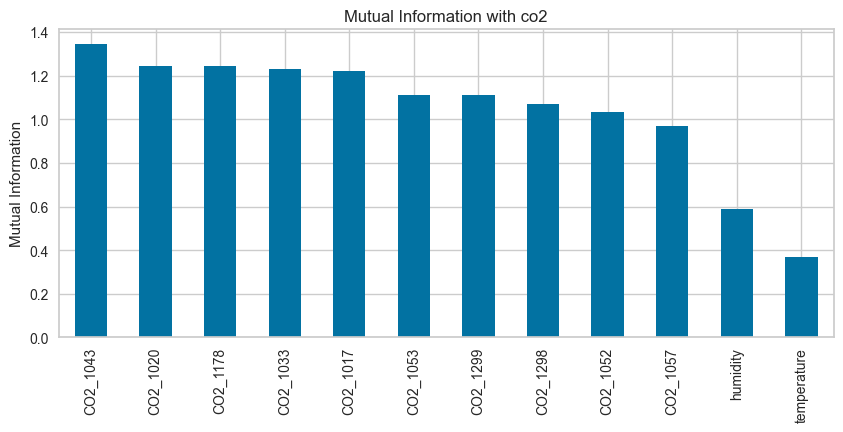

In [68]:
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information between each feature and the target
X = pre_drift[covariates]
y = pre_drift['CO2']
mi = pd.Series(mutual_info_regression(X, y), index=X.columns)

# Plot the mutual information
mi.sort_values(ascending=False).plot.bar(figsize=(10, 4))
plt.title('Mutual Information with co2')
plt.ylabel('Mutual Information')
plt.show()

 Straight away, we notice that humidity and temperature and no longer in our top 3 features. Indeed, using mutual information, we find that the CO2-measurements of sensors 1043, 1020 and 1078 are most relevant to our malfunctioning sensor's CO2 measurements. It is also worth noting that features 2-5 share similar MI values, suggesting any two from the set would serve well as our second and third features.

In [127]:
selected_features = mi.sort_values(ascending=False).index[:3]

cross_validation_and_plot(linreg_df, selected_features, f'Using Mutual Information for Feature Selection. Selected features: {list(selected_features)}')

Errors statistics:
Mean: -0.77; STD: 11.85
Pre-drift RMSE: 10.569308869947394


 Our results are a tad improved over our previous feature selection round, as evidenced by a drop in pre-drift RMSE from 11.9 to 10.6. This suggests Mutual Information is more successful than RFE for our data and model architecture. Even so, as with RFE, we cannot beat the pre-drift RMSE of the model with all twelve features. 
 
 One perhaps surprising fact is that under feature selection via MI, we no longer use any target sensor readings at all to predict post-drift values.

### e) **5/35**

Eventually, you'd like to try something new - __Bayesian Structural Time Series Modelling__ - to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 24. You will use:
- the information of provided by similar sensors - the ones you identified in question c)
- the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/jamalsenouci/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](https://github.com/jamalsenouci/causalimpact/blob/HEAD/GettingStarted.ipynb) with examples of how to use the python package.

- Report your findings:
    - Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?
    - Can you try to explain the results?

In [ ]:
!pip install causalimpact

In [ ]:
from causalimpact import CausalImpact
data = linreg_df.set_index('timestamp')
# Putting CO2 column on the first place
CO2 = data.pop('CO2')
data.insert(0, 'CO2', CO2)

pre_drift_last_ts = linreg_df[linreg_df.timestamp.dt.day < 24].timestamp.max()
post_drift_first_ts = linreg_df[linreg_df.timestamp.dt.day >= 24].timestamp.min()
pre_period = [linreg_df.timestamp.min(), pre_drift_last_ts]
post_period = [post_drift_first_ts, linreg_df.timestamp.max()]

impact = CausalImpact(data, pre_period, post_period)
impact.run()

In [ ]:
impact.plot()

In [ ]:
impact.summary(output="report")

- Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements? Can you try to explain the results?

Observing the second graph above (the one titled 'Difference'), we find that the confidence interval around the difference between the actual CO2 measurements and counterfactual reconstruction of CO2 measurements does not include zero in the first day or two of the post-drift time period, while it does thereafter. We conclude that the counterfactual reconstruction of CO2 measurements is at least temporarily significantly different from the observed measurements. As for why the observed measurements cross into the CI around the reconstructed counterfactual later in the post-drift period, we suspect that as time passes, even with post-drift feature variable measurements, the precision of our counterfactual CO2 estimate becomes less precise. In earlier parts, we were making the crucial assumption that the error of our predictions were independent of time, resulting in a stable confidence interval. Not so in the model underpinning the causalimpact package. 

A more numeric analysis of the drift can be seen below.

# That's all, folks!

A